In [1]:
import numpy as np
from scipy import stats, sparse
import matplotlib.pyplot as plt

N = 50
M = 100
K = 50
sigma = 0.2
r = 0.05
T = 1


# 1) Tracer le prix EDP du call européen dans le modèle de Black & Scholes en fonction de S0. Tracer l’écart entre ces prix en fonction de S0.

In [2]:
def black_scholes_call_price(S0, K, r, sigma, T):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)

### EDP (Black-Scholes)

L'EDP de Black-Scholes avec transformations logarithmiques est donnée par:
$
\frac{\partial u}{\partial \tau}(\tau, y) - \frac{\sigma^2}{2} \frac{\partial^2 u}{\partial y^2}(\tau, y) - \left( r - \frac{\sigma^2}{2} \right) \frac{\partial u}{\partial y}(\tau, y) + ru(t, y) = 0,
$

where:
- \( u = u($\tau$, y) \) est le prix de l'option en foncton du log prix de l'action \( y \) et du temps \( $\tau$ \),
- \( $\sigma$ \) est la volatilité de l'action
- \( r \) est le taux d'intérêt sans risque

### Méthode aux différences finies

La discrétisation aux différences finies mène aux coefficients \(a\), \(b\), et \(c\) tels que:

$
a = -\frac{\sigma^2}{2 \Delta y^2} + \frac{r - \sigma^2}{2 \Delta y}
$

$
b = r + \frac{\sigma^2}{\Delta y^2}
$

$
c = -\frac{\sigma^2}{2 \Delta y^2} - \frac{r - \sigma^2}{2 \Delta y}
$

où \( $\Delta y $\) est le pas de la discrétisation en espace.

In [3]:
def compute_W(a, b, c, V0, VM, N):
    M = len(b) + 1
    W = np.zeros(N - 1)
    W[0] = a[0] * V0
    W[-1] = c[-1] * VM
    return W

def call_explicit(K, T, r, sigma, N, M):
    dt = T / M
    y_min = 1
    y_max = np.log(K*2)
    dy = (y_max - y_min) / N
    y = np.linspace(y_min, y_max, N + 1)
    t = np.linspace(0, T, M + 1)
    U = np.zeros((M + 1, N + 1))

    U[:, -1] = np.exp(y_max) - np.exp(-r * (T - t)) * K # top boundary condition
    U[:, 0] = np.zeros(t.shape) # bottom boundary condition
    U[-1, :] = np.maximum(np.exp(y) - K, 0) # final boundary condition

    r_sigma2 = r - sigma**2
    a = -sigma**2/(2* dy**2 ) + r_sigma2/(2*dy) * np.ones(len(y)-2)
    b = r + sigma**2 /(dy**2) * np.ones(len(y)-2)
    c =  -sigma**2 /(2* dy**2 ) - r_sigma2/(2*dy) * np.ones(len(y)-2)

    Lambda = sparse.diags([a[1:], b, c[:-1]], offsets=[-1, 0, 1], format='csr')
    identity = sparse.identity(N - 1, format='csr')

    for i in range(M, 0, -1):
        W = compute_W(a, b, c, U[i, 0], U[i, N], N)
        U[i - 1, 1:N] = (identity - Lambda * dt).dot(U[i, 1:N]) - W * dt

    return U, t, np.exp(y)

In [4]:
explicit_prices,t,S = call_explicit(K, T, r, sigma, N, M)

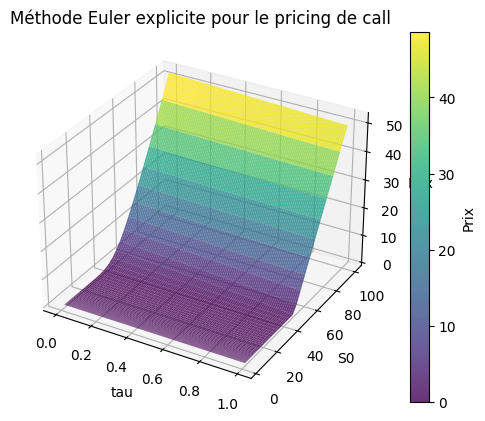

In [5]:
t_mesh, S_mesh = np.meshgrid(t,S)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(t_mesh, S_mesh, explicit_prices.T, cmap='viridis', rstride=1, cstride=1, alpha=0.8, antialiased=True)

fig.colorbar(surf, ax=ax, label='Prix')

ax.set_xlabel('tau')
ax.set_ylabel('S0')
ax.set_zlabel('Prix')
ax.set_title('Méthode Euler explicite pour le pricing de call')

plt.show()

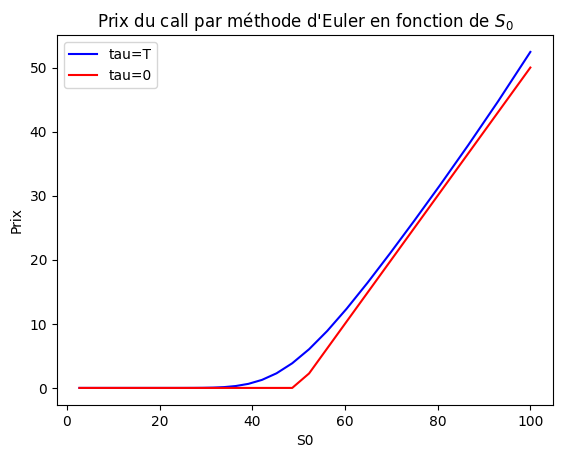

In [6]:
plt.plot(S, (explicit_prices)[0], label="tau=T", color="blue")
plt.plot(S, (explicit_prices)[-1], label="tau=0", color="red")
plt.xlabel("S0")
plt.ylabel("Prix")
plt.title(f"Prix du call par méthode d'Euler en fonction de $S_0$")
plt.legend()

In [7]:
bs_prices = []
for ti in np.flip(np.linspace(0, T, M+1)):
  bs_prices.append(black_scholes_call_price(S, K, r, sigma, ti))

<ipython-input-2-eed40d80cf2a>:2: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


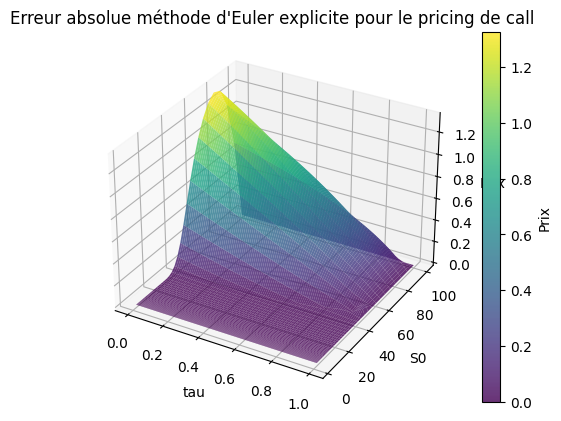

In [8]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(t_mesh, S_mesh, np.abs(bs_prices-explicit_prices).T, cmap='viridis', rstride=1, cstride=1, alpha=0.8, antialiased=True)

fig.colorbar(surf, ax=ax, label='Prix')

ax.set_xlabel('tau')
ax.set_ylabel('S0')
ax.set_zlabel('Prix')
ax.set_title("Erreur absolue méthode d'Euler explicite pour le pricing de call")

plt.show()

In [9]:
def call_implicit(K, T, r, sigma, N, M):
    dt = T / M
    y_min = 1
    y_max = np.log(K*2)
    dy = (y_max - y_min) / N
    y = np.linspace(y_min, y_max, N + 1)
    t = np.linspace(0, T, M + 1)
    U = np.zeros((M + 1, N + 1))

    U[:, -1] = np.exp(y_max) - np.exp(-r * (T - t)) * K # top boundary condition
    U[:, 0] = np.zeros(t.shape) # bottom boundary condition
    U[-1, :] = np.maximum(np.exp(y) - K, 0) # final boundary condition

    r_sigma2 = r - sigma**2
    a = -sigma**2/(2* dy**2 ) + r_sigma2/(2*dy) * np.ones(len(y)-2)
    b = r + sigma**2 /(dy**2) * np.ones(len(y)-2)
    c =  -sigma**2 /(2* dy**2 ) - r_sigma2/(2*dy) * np.ones(len(y)-2)

    Lambda = sparse.diags([a[1:], b, c[:-1]], offsets=[-1, 0, 1], format='csr')
    identity = sparse.identity(N - 1, format='csr')

    for i in range(M-1,-1,-1):
         W = compute_W(a,b,c,U[i,0],U[i,N], N)
         U[i,1:N] = sparse.linalg.spsolve(identity+Lambda*dt,U[i+1,1:N] - W*dt)
    return U, t, np.exp(y)

In [10]:
implicit_prices,t,S = call_implicit(K, T, r, sigma, N, M)

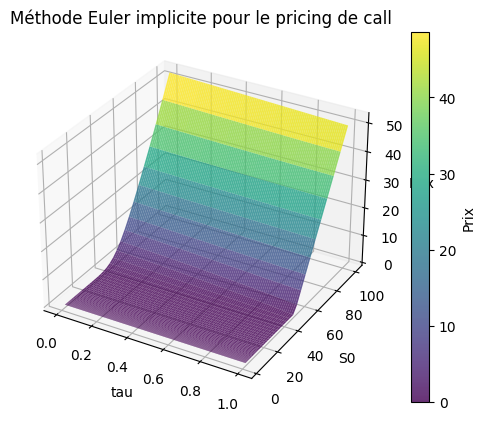

In [11]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(t_mesh, S_mesh, explicit_prices.T, cmap='viridis', rstride=1, cstride=1, alpha=0.8, antialiased=True)

fig.colorbar(surf, ax=ax, label='Prix')

ax.set_xlabel('tau')
ax.set_ylabel('S0')
ax.set_zlabel('Prix')
ax.set_title('Méthode Euler implicite pour le pricing de call')

plt.show()

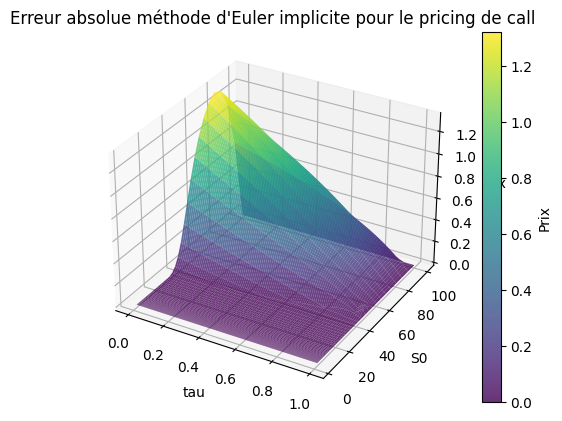

In [12]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(t_mesh, S_mesh, np.abs(bs_prices-implicit_prices).T, cmap='viridis', rstride=1, cstride=1, alpha=0.8, antialiased=True)

fig.colorbar(surf, ax=ax, label='Prix')

ax.set_xlabel('tau')
ax.set_ylabel('S0')
ax.set_zlabel('Prix')
ax.set_title("Erreur absolue méthode d'Euler implicite pour le pricing de call")

plt.show()

In [13]:
def call_crank_nicholson(K, T, r, sigma, N, M):
    dt = T / M
    y_min = 1
    y_max = np.log(K*2)
    dy = (y_max - y_min) / N
    y = np.linspace(y_min, y_max, N + 1)
    t = np.linspace(0, T, M + 1)
    U = np.zeros((M + 1, N + 1))

    U[:, -1] = np.exp(y_max) - np.exp(-r * (T - t)) * K # top boundary condition
    U[:, 0] = np.zeros(t.shape) # bottom boundary condition
    U[-1, :] = np.maximum(np.exp(y) - K, 0) # final boundary condition

    r_sigma2 = r - sigma**2
    a = -sigma**2/(2* dy**2 ) + r_sigma2/(2*dy) * np.ones(len(y)-2)
    b = r + sigma**2 /(dy**2) * np.ones(len(y)-2)
    c =  -sigma**2 /(2* dy**2 ) - r_sigma2/(2*dy) * np.ones(len(y)-2)

    Lambda = sparse.diags([a[1:], b, c[:-1]], offsets=[-1, 0, 1], format='csr')
    identity = sparse.identity(N - 1, format='csr')

    for i in range(M-1,-1,-1):
      Wt = compute_W(a,b,c,U[i,0],U[i,N], N)
      Wt_plus_dt = compute_W(a,b,c,U[i+1,0],U[i+1,N], N)
      U[i,1:N] = sparse.linalg.spsolve(identity+0.5*Lambda*dt,(identity-0.5*Lambda*dt).dot(U[i+1,1:N]) -0.5*dt*(Wt_plus_dt + Wt))
    return U, t, np.exp(y)

In [14]:
cn_prices,t,S = call_crank_nicholson(K, T, r, sigma, N, M)

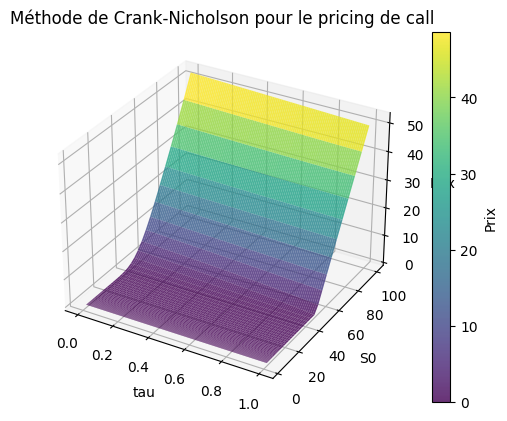

In [15]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(t_mesh, S_mesh, cn_prices.T, cmap='viridis', rstride=1, cstride=1, alpha=0.8, antialiased=True)

fig.colorbar(surf, ax=ax, label='Prix')

ax.set_xlabel('tau')
ax.set_ylabel('S0')
ax.set_zlabel('Prix')
ax.set_title('Méthode de Crank-Nicholson pour le pricing de call')

plt.show()

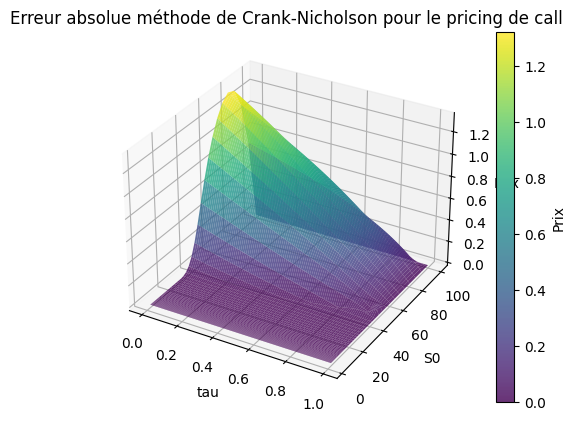

In [16]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(t_mesh, S_mesh, np.abs(bs_prices-cn_prices).T, cmap='viridis', rstride=1, cstride=1, alpha=0.8, antialiased=True)

fig.colorbar(surf, ax=ax, label='Prix')

ax.set_xlabel('tau')
ax.set_ylabel('S0')
ax.set_zlabel('Prix')
ax.set_title("Erreur absolue méthode de Crank-Nicholson pour le pricing de call")

plt.show()

Nous remarquons qu'à tau fixé, l'erreur est maximal au strike. Cela est dû à la discontinuité du payoff au strike. Par ailleurs, nous remaruqons également une instabilité de la méthode à maturité (tau=0). Dans tout ce qui suit, la méthode utilisée sera celle de Crank-Nicholson.

## 2) Tracer l’erreur en norme ∥ · ∥∞ du vecteur de prix EDP en fonction de N (à M suffisamment grand fixé). Retrouve-t-on l’ordre de convergence attendu ? Interpréter la forme de la courbe.

In [17]:
N_values = np.linspace(5, 100, 20)
N_values = np.logspace(1, 3, num=50, endpoint=True, base=10.0, dtype=None, axis=0)
M = 100

errors_cn_n = np.zeros(len(N_values))

for i, n in enumerate(N_values):
    cn_prices,t,S = call_crank_nicholson(K, T, r, sigma, int(n), M)
    price_bs = black_scholes_call_price(S, K, r, sigma, T)
    errors_cn_n[i] = np.max(np.abs(price_bs - cn_prices[0]))

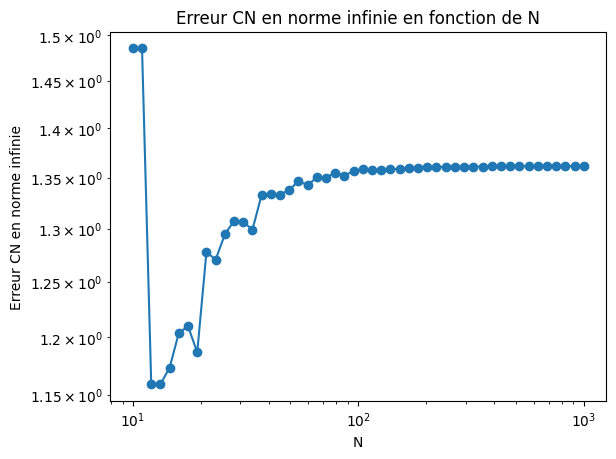

In [18]:
plt.plot(N_values, errors_cn_n, marker='o')
plt.yscale("log")
plt.xscale("log")
plt.xlabel('N')
plt.ylabel('Erreur CN en norme infinie')
plt.title('Erreur CN en norme infinie en fonction de N')
plt.show()

Ici, nous traçons l'erreur en norme infinie du vecteur de prix EDP (vecteur selon S0) en fonction de M. Malheureusement, nous ne retrouvons pas l'ordre de congerence attendu. Il semble que cela soit dû à l'instabilité observée à tau=0 (t=T).

# 3) Tracer l’erreur en norme ∥ · ∥∞ du vecteur de prix EDP en fonction de M (à N suffisamment grand fixé). Retrouve-t-on l’ordre de convergence attendu ? Interpréter la forme de la courbe.

In [19]:
M_values = np.linspace(5, 50, 20)
N_values = np.logspace(1, 4, num=50, endpoint=True, base=10.0, dtype=None, axis=0)
N = 50

errors_cn_m = np.zeros(len(M_values))

for i, m in enumerate(M_values):
    cn_prices,t,S = call_crank_nicholson(K, T, r, sigma, N, int(m))
    price_bs = black_scholes_call_price(S, K, r, sigma, T)
    errors_cn_m[i] = np.max(np.abs(price_bs - cn_prices[0]))

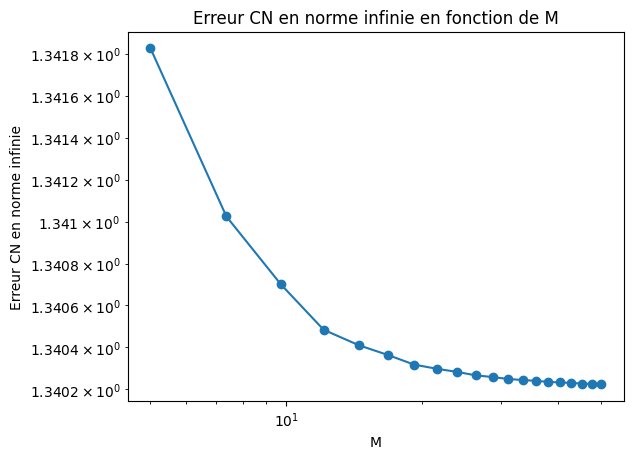

In [20]:
plt.plot(M_values, errors_cn_m, marker='o')
plt.yscale("log")
plt.xscale("log")
plt.xlabel('M')
plt.ylabel('Erreur CN en norme infinie')
plt.title('Erreur CN en norme infinie en fonction de M')
plt.show()

Ici, nous traçons l'erreur en norme infinie du vecteur de prix EDP (vecteur selon S0) en fonction de N. Malheureusement, ici également nous ne retrouvons pas l'ordre de congerence attendu. Il semble que cela soit dû à l'instabilité observée à tau=0 (t=T).

# 4) Tracer l'erreur ponctuelle |uij − u(jΔT,yi)| en fonction de t=T−jΔT et S=exp(y_i)

In [21]:
N = 100
M = 50
cn_prices,t,S = call_crank_nicholson(K, T, r, sigma, N, M)

In [22]:
bs_prices_stacked = np.zeros((len(t), (len(S))))
cn_prices_stacked = np.zeros(len(S))

for j, tj in enumerate(t):
    bs_prices_stacked[j] = black_scholes_call_price(S, K, r, sigma, tj)
    cn_prices_stacked = np.vstack((cn_prices_stacked, cn_prices[-j]))
errors_abs = np.abs((cn_prices_stacked)[1:] - bs_prices_stacked)

<ipython-input-2-eed40d80cf2a>:2: RuntimeWarning: divide by zero encountered in divide
  d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


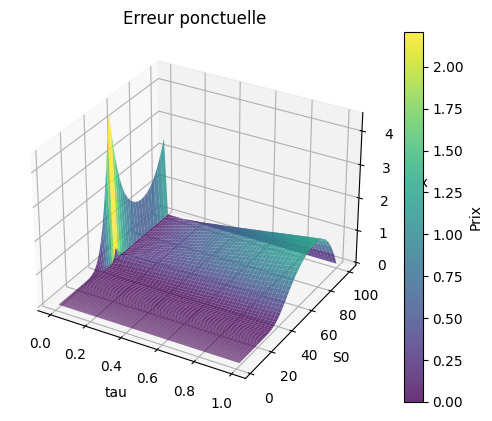

In [23]:
t_mesh, S_mesh = np.meshgrid(t,S)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(t_mesh, S_mesh, errors_abs.T, cmap='viridis', rstride=1, cstride=1, alpha=0.8, antialiased=True)

fig.colorbar(surf, ax=ax, label='Prix')

ax.set_xlabel('tau')
ax.set_ylabel('S0')
ax.set_zlabel('Prix')
ax.set_title("Erreur ponctuelle")

plt.show()

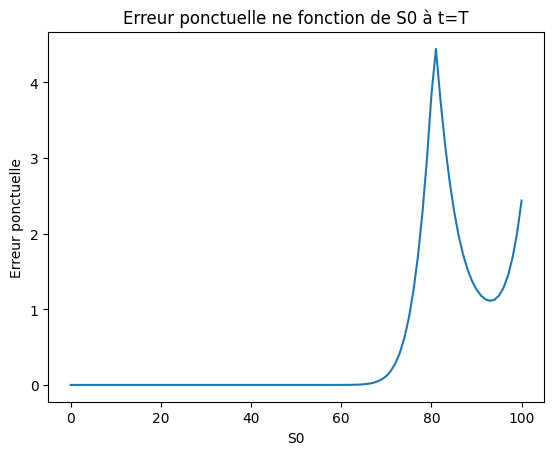

In [24]:
plt.plot(errors_abs[0])
plt.xlabel('S0')
plt.ylabel('Erreur ponctuelle')
plt.title('Erreur ponctuelle ne fonction de S0 à t=T')
plt.show()

Nous remarquons deux points importants sur l'erreur poncutelle observée. Le premier est que l'erreur est maximale pour S0=K. Cela est normal et dû au profil du payoff à maturité d'une option européenne. Le deuxième est que nous observons une instabilité importante à tau=0. Cela semble être une instabilité numérique car les conditions aux bords ont bien été spécifiées.